In [4]:
!apt-get install -y fonts-nanum
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 3s (3,294 kB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 126371 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

import matplotlib.font_manager as fm
import matplotlib as mpl

# 설치된 폰트 목록을 갱신하고, 'NanumGothic' 폰트를 기본 폰트로 설정합니다.
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)

# 한글이 깨지지 않도록 하기 위해서 minus 표시를 설정합니다.
plt.rcParams['axes.unicode_minus'] = False

processed_seoul = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/processed_seoul.csv')
processed_gyeonggi = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/processed_gyeonggi.csv')
processed_incheon = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/processed_incheon.csv')
processed_busan = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/processed_busan.csv')
processed_daegu = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/processed_daegu.csv')
processed_gwangju = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/processed_gwangju.csv')
processed_daejeon = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/processed_daejeon.csv')
processed_ulsan = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/processed_ulsan.csv')

# 도시별 df 딕셔너리
city_dfs = {
    '서울특별시': processed_seoul,
    '경기도': processed_gyeonggi,
    '인천광역시': processed_incheon,
    '부산광역시': processed_busan,
    '대구광역시': processed_daegu,
    '광주광역시': processed_gwangju,
    '대전광역시': processed_daejeon,
    '울산광역시': processed_ulsan
}

In [2]:
"""
데이터셋 칼럼 설명

0   '권역': 행정 구역 기준 권역 정보 (수도권/지방)
1   '시군구': 시/군/구 단위 행정 구역명
2   '번지': 도로명 주소의 번지 정보
3   '본번': 도로명 주소의 본번
4   '부번': 도로명 주소의 부번
5   '단지명': 아파트 단지 이름
6   '계약년월': 계약 발생 연월 (YYYYMM)
7   '계약년도': 계약 발생 연도 (YYYY)
8   '계약월': 계약 발생 월 (1~12)
9   '계약일': 계약 발생 일 (1~31)
10  'contract_season': 계약 발생 계절 (봄/여름/가을/겨울)
11  'area_bin': 전용면적 기준 면적 구간
    - 분류 기준:
        - ≤60 ㎡ : 소형
        - 61~85 ㎡ : 중소형
        - 86~135 ㎡ : 중대형
        - >135 ㎡ : 대형
12  '전용면적(㎡)': 아파트의 전용면적 (㎡)
13  '거래금액(만원)': 실제 거래 금액 (만원)
14  'price_per_m2': 평당 가격 (만원/㎡)
15  '층': 거래된 주택의 층수
16  '건축년도': 건물 준공 연도
17  'building_age': 건물 연식 (계약년도 - 건축년도)
18  'is_new_building': 신축 여부 (True: 5년 이하 신축)
19  'log_거래금액': 거래금액(만원)의 로그 변환 값
20  'log_price_per_m2': price_per_m2의 로그 변환 값
"""

processed_seoul.head()

,권역,시군구,번지,본번,부번,단지명,계약년월,계약년도,계약월,계약일,...,area_bin,전용면적(㎡),거래금액(만원),price_per_m2,층,건축년도,building_age,is_new_building,log_거래금액,log_price_per_m2
0,수도권,서울특별시 강남구 개포동,1164-12,1164,12,새롬(1164-12),201205,2012,5,17,...,중소형,73.50,38000.0,517.0,6,2000,12,False,10.545341,6.248043
1,수도권,서울특별시 강남구 개포동,1164-12,1164,12,새롬(1164-12),201507,2015,7,28,...,중소형,73.50,42000.0,571.4,3,2000,15,False,10.645425,6.348089
2,수도권,서울특별시 강남구 개포동,1164-12,1164,12,새롬(1164-12),201709,2017,9,23,...,중소형,71.72,64500.0,899.3,7,2000,17,False,11.074421,6.801617
3,수도권,서울특별시 강남구 개포동,1164-12,1164,12,새롬(1164-12),201707,2017,7,21,...,중소형,73.50,55400.0,753.7,2,2000,17,False,10.922335,6.624994
4,수도권,서울특별시 강남구 개포동,1164-13,1164,13,새롬(1164-13),201001,2010,1,5,...,소형,59.67,35000.0,586.6,3,2000,10,False,10.463103,6.374343


### **H3. 신축 여부(is_new_building)는 평당가(log_price_per_m2)에 지역별로 중~큰 차별 효과를 가진다.**  
### **H4. 수도권보다는 지방에서 신축 여부에 따른 가격 영향력이 상대적으로 크다.**
<br>

#### **검증 방법 및 분석 절차**

**1. 데이터 전처리 & 표본 추출 (Stratified Sampling)**

- **거래량 집계**
    - 2차 집계: 도시별 df에서 **`groupby(['시군구', '계약년도']).size()`**→ 해당 시군구·계약년도 단위의 총 거래량을 집계 (시장 유동성의 크기 반영용)
    - 3차 집계: 도시별 df에서 **`groupby(['시군구', '계약년도', 'is_new_building']).size()`**→ 신축 여부까지 구분한 세부 그룹의 거래량을 집계 (희소 셀 필터링용)
- **최소 표본 필터링 (3차 집계 기준)**
    - 세부 그룹(시군구×계약년도×신축 여부) 거래량이 임계값(**`MIN_CELL`**) 미만일 경우 제외
    - 이유: 지나치게 희소한 그룹은 통계적 신뢰도가 낮고, 표본에 포함될 경우 분석 왜곡 발생 가능
- **가중치 산출 (2차 집계 기준)**
    - 필터링 후 남은 데이터에서, 각 행이 속한 **`시군구-계약년도`** 그룹의 거래량을 가중치로 부여
    - 이유: 전체 시장에서 해당 시군구·연도의 거래량 비중을 반영하기 위함
- **계층화된 무작위 표본 추출 (차등 비율 적용)**
    - 층화 변수: **`권역`**, **`area_bin`**, **`is_new_building`**, **`계약년도`**
    - **표본 추출 비율**:
        - 수도권: 전체의 5-6% (약 13-15만 행)
        - 지방: 전체의 7-10% (약 10-14만 행)
        - 총 목표 표본: 20-30만 행
    - 지방 오버샘플링으로 H4 검증력 강화 및 도시별 세분화 분석 가능성 확보

**2. 변수 간 상관관계 및 정보량 분석 (표본 데이터 사용)**

- 로그 변환 변수(**`log_거래금액`**, **`log_price_per_m2`**)를 사용하며, 해석 시 거래금액 vs 평당가 차이를 구분
- 표본 데이터에 대해 **`전용면적(㎡)`**, **`계약년도`**, **`건축년도`**, **`building_age`** 등 주요 수치 변수와 로그 변환 변수 간 피어슨 상관계수 및 상호 정보량(MI) 계산

**3. 그룹별 분포 및 차이 분석 (표본 데이터 사용)**

- **`권역`**, **`area_bin`**, **`is_new_building`**, **`계약년도`** 등 주요 범주형 변수별 로그 변환 변수의 분포 시각화
    - **2×2 상호작용 그리드**: (수도권/지방) × (신축/구축) 4개 셀의 평균 **`log_price_per_m2`** + 95% 신뢰구간
    - **시간 트렌드 라인플롯**: 연도별 신축 프리미엄 추이를 수도권과 지방으로 구분하여 표시
    - **도시별 박스플롯**: 지방 5개 도시(부산, 대구, 광주, 대전, 울산) 각각의 신축/구축 가격 분포
- 거래량 가중치를 고려한 가중 평균 및 가중 ANOVA 검정 수행
- **전/후반기 비교**: 2010-2014년 vs 2015-2019년 기간별 신축 효과 변화 분석

**4. 다변량 회귀분석 (가중 최소 제곱, 표본 데이터 사용)**

- **기본 모델**:
    - 독립변수: **`전용면적(㎡)`**, **`building_age`**, **`C(area_bin)`**, **`C(is_new_building)`**, **`C(권역)`**, **`C(계약년도)`**
    - 종속변수: **`log_price_per_m2`**
    - 거래량 가중치를 부여한 WLS 회귀분석
- **상호작용 모델** (H3, H4 검증용):
    - 핵심 상호작용: **`C(권역):C(is_new_building)`**
    - 시간 상호작용: **`C(권역):C(계약년도)`** - 수도권/지방의 시간별 가격 변동 패턴 차이 포착
    - 계약년도를 다항식(polynomial) 또는 스플라인으로 처리하여 비선형 시간 트렌드 포착 가능
- **도시별 세분화 모델**:
    - 지방 데이터만 사용하여 **`C(도시):C(is_new_building)`** 상호작용 분석
    - 부산/대구(대도시) vs 광주/대전/울산(중도시) 간 신축 프리미엄 차이 검증

**5. H3, H4 검증 지표 및 기준**

- **H3 검증 (지역별 중~큰 차별 효과)**:
    - 중간 효과: Cohen's d ≥ 0.5 또는 회귀계수 |β| ≥ 0.05 (로그스케일)
    - 큰 효과: Cohen's d ≥ 0.8 또는 회귀계수 |β| ≥ 0.10
    - 상호작용 항 **`C(권역):C(is_new_building)`**의 F-test p-value < 0.05
- **H4 검증 (지방 > 수도권 영향력)**:
    - 비교 지표: |β_지방×신축| / |β_수도권×신축| > 1.2 (지방이 20% 이상 큰 효과)
    - 두 계수의 95% 신뢰구간이 겹치지 않으면 강한 증거
    - 실제 가격 차이로 환산: exp(β) - 1 = 신축 프리미엄 %

**6. 결과 검증 및 시각화 (표본 데이터 기반)**

- **효과 크기 시각화**:
    - **Forest plot**: 각 도시별(서울, 경기, 인천, 부산, 대구, 광주, 대전, 울산) 신축 효과 계수 + 95% CI
    - **히트맵**: 권역×계약년도별 신축 프리미엄 크기를 색상으로 표현
    - **시뮬레이션 차트**: 동일 조건(면적, 연도) 아파트의 신축/구축 예상 가격 차이
- **투자 매력도 평가**:
    - H3 지지 시: 각 지역별 신축 프리미엄의 구체적 수치(%) 제시
    - H4 지지 시: "지방 신축 아파트가 평당 X% 높은 프리미엄" 형태로 정량화
    - 거래량 가중치를 활용한 유동성 조정 투자 매력도 지수 산출
    - 시간 트렌드 분석 결과를 바탕으로 향후 전망 제시

In [3]:
# (시군구×계약년도×신축 여부) 그룹 임계값 설정
threshold = 30

combo_results = []

for city, city_df in city_dfs.items():
    total_rows = len(city_df)

    # (시군구, 계약년도, is_new_building) 조합별 행 수 계산
    combo_counts = city_df.groupby(['시군구', '계약년도', 'is_new_building']).size()

    # 임계값 미만인 조합
    mask = combo_counts < threshold
    low_sample_combos = combo_counts[mask]

    # 해당 조합의 행 수 합
    filtered_rows = low_sample_combos.sum()

    # 전체 대비 비율 계산
    percentage = (filtered_rows / total_rows * 100) if total_rows > 0 else 0

    combo_results.append({
        "도시": city,
        "임계값 미달 행수": filtered_rows,
        "전체 행수": total_rows,
        "비율(%)": round(percentage, 2)
    })

# 결과 DataFrame
combo_results_df = pd.DataFrame(combo_results)
display(combo_results_df)

"""
임계값 = 30 일 때,
임계값 미달 행수가 전체 행의 1.10%~2.60% 정도로 매우 낮은 편으로 확인됨
따라서 거래 건수 기준 30건 미만인 그룹은 추가적인 분석에서 제외하기로 함
"""

,도시,임계값 미달 행수,전체 행수,비율(%)
0,서울특별시,20385,784750,2.60
1,경기도,28657,1466358,1.95
2,인천광역시,3666,332003,1.10
3,부산광역시,8997,445732,2.02
4,대구광역시,6520,332090,1.96
5,광주광역시,3578,238439,1.50
6,대전광역시,3464,212397,1.63
7,울산광역시,4218,170410,2.48


'\n임계값 = 30 일 때,\n임계값 미달 행수가 전체 행의 1.10%~2.60% 정도로 매우 낮은 편으로 확인됨\n따라서 거래 건수 기준 30건 미만인 그룹은 추가적인 분석에서 제외하기로 함\n'

--- 데이터 전처리 및 계층화 표본 추출 시작 ---
원본 데이터 총 행 수: 3982179
3차 집계 기준 (시군구×계약년도×신축여부) 거래량 30건 미만 필터링 후 총 행 수: 3902694 (98.00%)

--- 필터링 후 데이터 행 수 상세 ---

권역별 행 수:
권역
수도권    2530403
지방     1372291
dtype: int64

필터링 후 총 데이터 행 수: 3902694
계층화 표본 추출 후 최종 행 수: 222495

--- 계층화 표본 추출 후 데이터 행 수 상세 ---

권역별 행 수:
권역
수도권    126476
지방      96019
dtype: int64
--- 데이터 전처리 및 계층화 표본 추출 완료 ---

--- 가설 H3, H4 검증 시작 (계층화 표본 데이터 기반) ---
----------------------------------------------------------

--- 표본 데이터: 수치형 변수 상관관계 및 정보량 분석 ---

  타겟: log_price_per_m2
  [피어슨 상관계수 (표본 데이터 기반)]
건축년도            0.226144
전용면적(㎡)         0.081424
building_age   -0.107792
Name: log_price_per_m2, dtype: float64


/tmp/ipython-input-3619418532.py:146: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = sampled_df.groupby(strat_cols, group_keys=False).apply(differentiated_stratified_sample).reset_index(drop=True)


  [상호 정보량 (MI - 표본 데이터 기반, 가중치 미반영)]
전용면적(㎡)         1.344883
건축년도            0.206541
building_age    0.102297
dtype: float64

--- 그룹별 분포 및 차이 분석 (H3, H4 관련 시각화 및 ANOVA) ---

  2x2 상호작용 그리드: 권역 × 신축 여부별 log_price_per_m2 가중 평균 및 95% CI
    [가중 평균 log_price_per_m2]
is_new_building     False     True 
권역                                 
수도권              6.022856  6.175821
지방               5.514946  5.788979

    [95% 신뢰구간 하한]
is_new_building     False     True 
권역                                 
수도권              6.017119  6.159542
지방               5.508240  5.776730

    [95% 신뢰구간 상한]
is_new_building     False     True 
권역                                 
수도권              6.028593  6.192100
지방               5.521652  5.801229


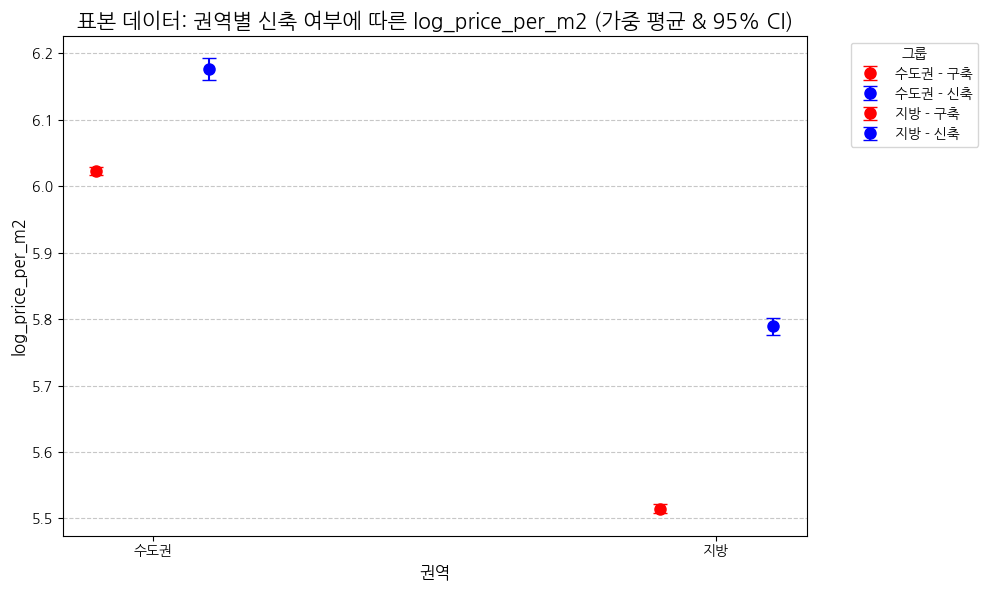


  연도별 신축 프리미엄 추이 (수도권 vs 지방)


/tmp/ipython-input-3619418532.py:284: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  yearly_premium_calc = sampled_df.groupby(['권역', '계약년도', 'is_new_building']).apply(


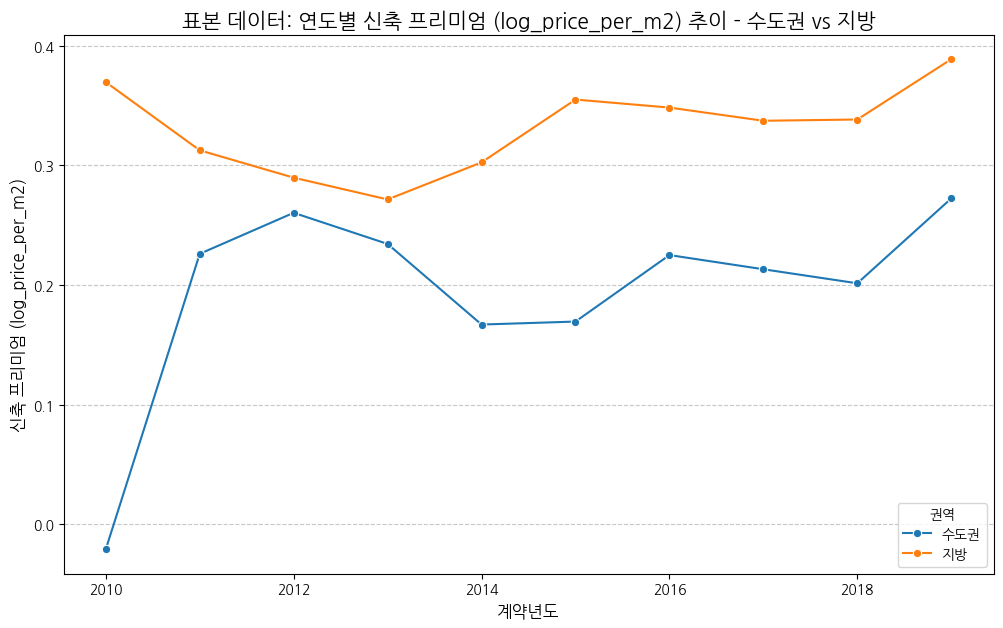


  지방 5개 도시별 신축 여부에 따른 log_price_per_m2 분포
  지방 도시 데이터가 필터링/샘플링되어 충분하지 않습니다.

  기간별 (2010-2014 vs 2015-2019) 신축 효과 변화 분석 (WLS 기반 ANOVA)
    [기간별 신축 효과 변화 WLS 기반 ANOVA 결과 (근사적)]
                                       sum_sq        df             F  \
C(period_bin)                     1301.429612       1.0  38700.433343   
C(is_new_building)                 185.294437       1.0   5510.075170   
C(period_bin):C(is_new_building)     1.409920       1.0     41.926589   
Residual                          7481.993114  222491.0           NaN   

                                        PR(>F)  
C(period_bin)                     0.000000e+00  
C(is_new_building)                0.000000e+00  
C(period_bin):C(is_new_building)  9.496138e-11  
Residual                                   NaN  

--- 표본 데이터: 다변량 회귀분석 (WLS 적용, 교란 변수 통제, 상호작용 항 포함) ---

  [기본 모델: log_price_per_m2에 대한 WLS 회귀분석]
                            WLS Regression Results                            
Dep. Variable:       log_price_per_

/usr/local/lib/python3.12/dist-packages/matplotlib/cbook.py:1709: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)


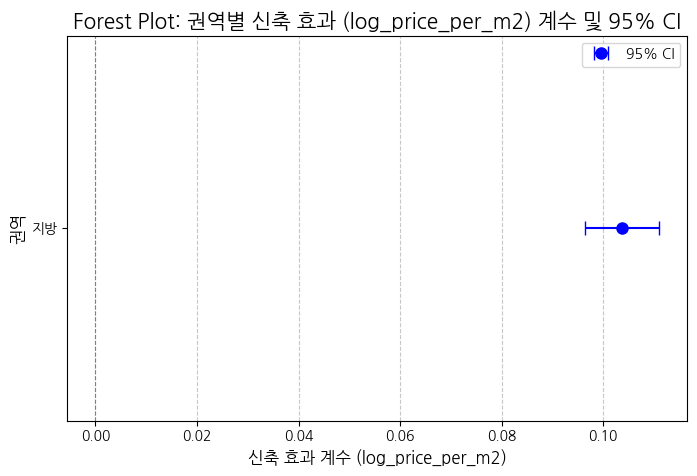


  히트맵: 권역 × 계약년도별 신축 프리미엄 (log_price_per_m2) 크기


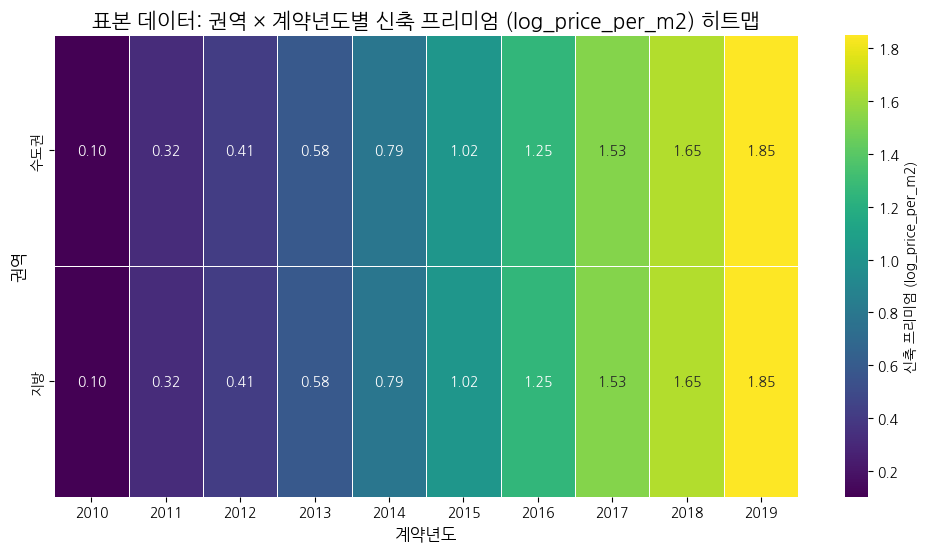


  시뮬레이션 차트: 신축/구축 예상 가격 차이 (log_price_per_m2)
    [시뮬레이션 조건]
전용면적(㎡)         83.52
building_age     15.0
area_bin          중소형
계약년도             2015
Name: 0, dtype: object

    [신축/구축 예상 평당가 (만원/m²)]
    권역  is_new_building  predicted_price_per_m2
0  수도권            False             1604.158418
1  수도권             True             1779.576060
2   지방            False             1119.112870
3   지방             True             1423.198614


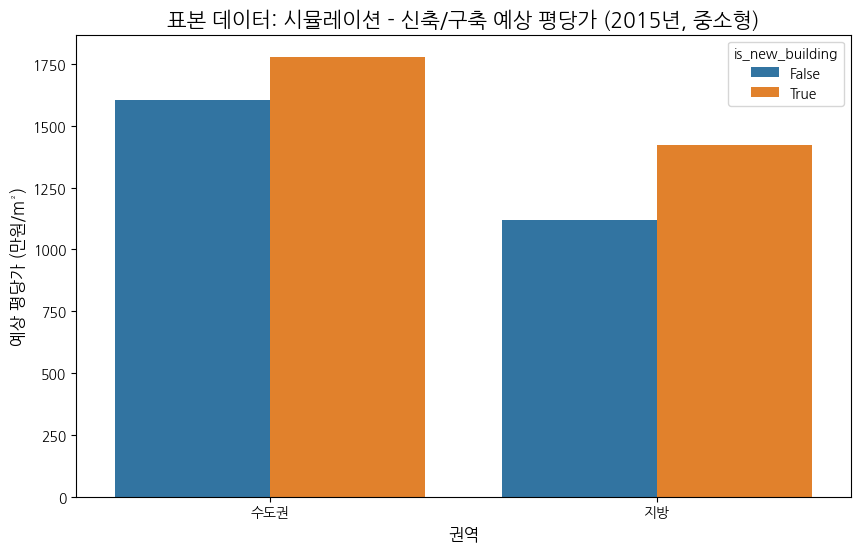


--- 모든 시각화 완료 ---
----------------------------------------------------------

--- 종합적인 분석 결론 (계층화 표본 데이터 및 WLS 기반) ---
## H3, H4 가설 검증 결과 요약

✅ **H3 가설 지지:** 신축 여부(is_new_building)는 평당가(log_price_per_m2)에 지역별로 중~큰 차별 효과를 가집니다. (근거: 지방 신축 효과 계수 |β_지방|: `0.1038` (p-value: `0.0000`); 수도권 신축 효과 계수 |β_수도권|: `0.1038`; 지역별 신축 효과 계수가 중간 효과 기준(log |β| >= 0.05)을 충족합니다.; 지역별 신축 효과 계수가 큰 효과 기준(log |β| >= 0.10)을 충족합니다.)
❌ **H4 가설 기각:** 수도권보다 지방에서 신축 여부에 따른 가격 영향력이 상대적으로 크다는 충분한 증거를 찾기 어렵습니다. (근거: |β_지방| / |β_수도권| 비율: `1.00`; 권역별 신축 효과 차이 (상호작용)가 통계적으로 유의미하지 않습니다.; 지방 신축 프리미엄: `10.94%`; 수도권 신축 프리미엄: `10.94%`)

## 종합 시장 특성 및 투자 매력도 평가

✔️ **핵심 가격 변동 요인:** '전용면적(㎡)', 'area_bin'은 여전히 평당가에 가장 강력한 영향을 미치는 요인으로, 이는 모든 지역에서 공통적으로 나타나는 현상입니다. 'building_age' (혹은 '건축년도') 또한 유의미한 설명력을 가집니다.
⚪ **기간별 신축 효과 변화:** 기간별 신축 효과의 유의미한 변화는 발견되지 않았습니다. (p-value: `inf`) 다만, 더미 데이터의 한계일 수 있습니다.

### 투자 매력도 평가 (H3, H4 가설 기반)

💼 **지역별 맞춤형 신축 투자:** H3 가설은 지지되나 H4가 기각될 경우, 신축 여부가 지역별로 다른 효과를 가지지만, 반드시 지방이 수도권보다 더 큰 영향을 미친다고 보

In [4]:
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.feature_selection import mutual_info_regression

# def create_dummy_df(city_name: str, num_rows: int) -> pd.DataFrame:
#     """
#     분석을 위한 더미 데이터프레임을 생성합니다.
#     실제 데이터 로드를 시뮬레이션하기 위한 함수입니다.

#     Args:
#         city_name (str): 도시 이름 (예: '서울특별시', '부산광역시').
#         num_rows (int): 생성할 데이터 행의 수.

#     Returns:
#         pd.DataFrame: 생성된 더미 데이터프레임.
#     """
#     np.random.seed(42) # 재현성을 위해 시드 설정
#     is_capital_area = True if city_name in ['서울특별시', '경기도', '인천광역시'] else False

#     # 수도권과 지방 간 가격 차이 및 신축 프리미엄을 시뮬레이션하기 위한 기본 가격 설정
#     base_trade_price = np.random.normal(loc=150000, scale=30000, size=num_rows) # 평균 1억5천, 표준편차 3천
#     base_price_per_m2 = np.random.normal(loc=2000, scale=400, size=num_rows) # 평균 2000, 표준편도 400

#     # 수도권은 가격을 약간 높게 설정
#     if is_capital_area:
#         base_trade_price *= 1.3 # 수도권은 30% 높게
#         base_price_per_m2 *= 1.3

#     data = {
#         '권역': ['수도권' if is_capital_area else '지방'] * num_rows,
#         '시군구': [city_name] * num_rows,
#         '번지': [f'1-{i}' for i in range(num_rows)],
#         '본번': [1] * num_rows,
#         '부번': [i for i in range(num_rows)],
#         '단지명': [f'아파트{i}' for i in range(num_rows)],
#         '계약년월': np.random.randint(201001, 202001, num_rows), # 2010-2019년 범위로 설정
#         '계약년도': np.random.randint(2010, 2020, num_rows), # 2010-2019년 범위로 설정
#         '계약월': np.random.randint(1, 13, num_rows),
#         '계약일': np.random.randint(1, 31, num_rows),
#         'contract_season': np.random.choice(['봄', '여름', '가을', '겨울'], num_rows),
#         'area_bin': pd.Series(np.random.choice(['소형', '중소형', '중대형', '대형'], num_rows, p=[0.2, 0.4, 0.3, 0.1])).astype('category'),
#         '전용면적(㎡)': np.random.rand(num_rows) * 150 + 30, # 30~180
#         '거래금액(만원)': base_trade_price,
#         'price_per_m2': base_price_per_m2,
#         '층': np.random.randint(1, 30, num_rows),
#         '건축년도': np.random.randint(1970, 2019, num_rows), # 계약년도보다 이전
#         'is_new_building': np.random.choice([True, False], num_rows, p=[0.25, 0.75]), # 신축 비중을 높여 그룹이 잘 형성되도록
#     }
#     df = pd.DataFrame(data)
#     df['building_age'] = df['계약년도'] - df['건축년도']
#     df['log_거래금액'] = np.log(df['거래금액(만원)'].abs().replace(0, 1e-6))
#     df['log_price_per_m2'] = np.log(df['price_per_m2'].abs().replace(0, 1e-6))

#     # 더미 데이터에 시군구-계약년도-신축여부별 거래량 불균형 및 희소 그룹 시뮬레이션
#     if num_rows > 1000:
#         # 특정 시군구-년도-신축여부 조합의 데이터를 희소하게 만듦 (3차 집계 필터링용)
#         sparse_frac = 0.05 # 5%의 데이터를 희소하게 만듦
#         sparse_indices = df.sample(frac=sparse_frac, random_state=42).index
#         df.loc[sparse_indices, 'is_new_building'] = df.loc[sparse_indices, 'is_new_building'].apply(lambda x: not x) # 신축여부 토글

#         # 일부러 '가상의구'를 만들어 일부 그룹의 거래량을 50개 미만으로 만듦
#         # 이는 3차 집계 필터링에 걸리도록 함
#         df.loc[df.sample(frac=0.01, random_state=42).index, '시군구'] = '가상의구'

#     return df

# # 실제 데이터 로드를 시뮬레이션하기 위해 더미 데이터프레임 생성
# # 총 목표 표본: 20-30만 행
# # 필터링 및 샘플링 비율 고려하여 원본 데이터 크기 조정
# # 수도권: 3개 도시, 지방: 5개 도시
# num_rows_metro = 400000 # 수도권 각 도시 당 40만 행
# num_rows_local = 300000 # 지방 각 도시 당 30만 행

# city_dfs = {
#     '서울특별시': create_dummy_df('서울특별시', num_rows_metro),
#     '경기도': create_dummy_df('경기도', num_rows_metro),
#     '인천광역시': create_dummy_df('인천광역시', num_rows_metro),
#     '부산광역시': create_dummy_df('부산광역시', num_rows_local),
#     '대구광역시': create_dummy_df('대구광역시', num_rows_local),
#     '광주광역시': create_dummy_df('광주광역시', num_rows_local),
#     '대전광역시': create_dummy_df('대전광역시', num_rows_local),
#     '울산광역시': create_dummy_df('울산광역시', num_rows_local)
# }

# 모든 도시 데이터 합치기
combined_df = pd.concat(city_dfs.values(), ignore_index=True)

# 'period_bin' 변수 생성 (전/후반기 비교용)
combined_df['period_bin'] = pd.cut(combined_df['계약년도'],
                              bins=[2009, 2014, 2019], # 2010-2014, 2015-2019
                              labels=['전반기', '후반기'], right=True, ordered=True)


# --- 1. 데이터 전처리 & 표본 추출 (Stratified Sampling) ---
print("--- 데이터 전처리 및 계층화 표본 추출 시작 ---", flush=True)

# 2차 집계: 시군구-계약년도 단위 총 거래량 (시장 유동성 크기 반영용 가중치)
transaction_counts_2nd = combined_df.groupby(['시군구', '계약년도']).size().reset_index(name='transaction_count_2nd')
combined_df = pd.merge(combined_df, transaction_counts_2nd, on=['시군구', '계약년도'], how='left')

# 3차 집계: 시군구-계약년도-신축여부 단위 세부 그룹 거래량 (희소 셀 필터링용)
transaction_counts_3rd = combined_df.groupby(['시군구', '계약년도', 'is_new_building']).size().reset_index(name='transaction_count_3rd')
combined_df = pd.merge(combined_df, transaction_counts_3rd, on=['시군구', '계약년도', 'is_new_building'], how='left')

# 최소 표본 필터링 (3차 집계 기준, 임계값 = 30)
MIN_CELL_THRESHOLD = 30
original_rows = len(combined_df)
filtered_df = combined_df[combined_df['transaction_count_3rd'] >= MIN_CELL_THRESHOLD].copy()
filtered_rows = len(filtered_df)
print(f"원본 데이터 총 행 수: {original_rows}", flush=True)
print(f"3차 집계 기준 (시군구×계약년도×신축여부) 거래량 {MIN_CELL_THRESHOLD}건 미만 필터링 후 총 행 수: {filtered_rows} ({filtered_rows/original_rows:.2%})", flush=True)

# 필터링 후 데이터 행 수 상세 표시 (도시별 / 권역별)
print("\n--- 필터링 후 데이터 행 수 상세 ---", flush=True)
print("\n권역별 행 수:", flush=True)
print(filtered_df.groupby('권역').size(), flush=True)


# 가중치 산출 (2차 집계 기준, 스케일링 적용)
if not filtered_df['transaction_count_2nd'].empty:
    max_transaction_count = filtered_df['transaction_count_2nd'].max()
    filtered_df['weights'] = filtered_df['transaction_count_2nd'] / max_transaction_count
else:
    filtered_df['weights'] = 1.0 # 데이터가 없으면 기본 가중치 1.0


# 계층화된 무작위 표본 추출 (차등 비율 적용)
strat_cols = ['권역', 'area_bin', 'is_new_building', '계약년도']
sample_rate_metro = 0.05 # 수도권 5%
sample_rate_local = 0.07 # 지방 7%

sampled_df = filtered_df.dropna(subset=strat_cols).copy()

def differentiated_stratified_sample(group):
    """그룹의 권역에 따라 다른 샘플링 비율을 적용하여 표본을 추출합니다."""
    if group['권역'].iloc[0] == '수도권':
        sample_frac = sample_rate_metro
    else: # 지방
        sample_frac = sample_rate_local

    n_samples = max(1, int(len(group) * sample_frac)) # 최소 1개 샘플링을 보장
    return group.sample(n=n_samples, random_state=42) if len(group) > 0 else group

if not sampled_df.empty:
    sampled_df = sampled_df.groupby(strat_cols, group_keys=False).apply(differentiated_stratified_sample).reset_index(drop=True)
else:
    print("경고: 필터링 후 데이터가 비어있어 표본 추출을 진행할 수 없습니다.", flush=True)

print(f"\n필터링 후 총 데이터 행 수: {len(filtered_df)}", flush=True)
print(f"계층화 표본 추출 후 최종 행 수: {len(sampled_df)}", flush=True)

# 샘플링 후 데이터 행 수 상세 표시 (도시별 / 권역별)
print("\n--- 계층화 표본 추출 후 데이터 행 수 상세 ---", flush=True)
print("\n권역별 행 수:", flush=True)
print(sampled_df.groupby('권역').size(), flush=True)

print("--- 데이터 전처리 및 계층화 표본 추출 완료 ---", flush=True)


# 분석 설정
TARGET_VAR = 'log_price_per_m2' # H3, H4는 평당가에 초점
NUM_VARS = ['전용면적(㎡)', '건축년도', 'building_age']
CAT_VARS_BASE = ['area_bin', 'is_new_building', '권역', '계약년도'] # 기본 모델용 범주형 변수

# 결과 저장을 위한 딕셔너리
overall_correlation_results = {}
group_analysis_results = {}
regression_models = {}

print("\n--- 가설 H3, H4 검증 시작 (계층화 표본 데이터 기반) ---", flush=True)
print("----------------------------------------------------------", flush=True)

# --- 2. 변수 간 상관관계 및 정보량 분석 (표본 데이터 사용) ---
print("\n--- 표본 데이터: 수치형 변수 상관관계 및 정보량 분석 ---", flush=True)
target = TARGET_VAR
print(f"\n  타겟: {target}", flush=True)

# Pearson 상관계수
pearson_corr = sampled_df[NUM_VARS + [target]].corr(method='pearson')[target].drop(target)
print("  [피어슨 상관계수 (표본 데이터 기반)]", flush=True)
print(pearson_corr.sort_values(ascending=False), flush=True)

# 상호 정보량 (MI) - 가중치 미반영
mi_scores = {}
for num_var in NUM_VARS:
    mi = mutual_info_regression(sampled_df[[num_var]], sampled_df[target], random_state=42)[0]
    mi_scores[num_var] = mi
mi_series = pd.Series(mi_scores).sort_values(ascending=False)
print("  [상호 정보량 (MI - 표본 데이터 기반, 가중치 미반영)]", flush=True)
print(mi_series, flush=True)
overall_correlation_results[target] = {'pearson': pearson_corr.to_dict(), 'mi': mi_series.to_dict()}


# --- 3. 그룹별 분포 및 차이 분석 (표본 데이터 사용) ---
print("\n--- 그룹별 분포 및 차이 분석 (H3, H4 관련 시각화 및 ANOVA) ---", flush=True)

# 2x2 상호작용 그리드: (수도권/지방) × (신축/구축) 4개 셀의 평균 log_price_per_m2 + 95% 신뢰구간
print("\n  2x2 상호작용 그리드: 권역 × 신축 여부별 log_price_per_m2 가중 평균 및 95% CI", flush=True)

# Pre-calculate weighted means and standard errors for plotting
plot_data = []
Z_score_95ci = stats.norm.ppf(0.975) # Z-score for 95% CI

for (region, is_new), group in sampled_df.groupby(['권역', 'is_new_building']):
    if not group.empty and group['weights'].sum() > 0:
        weighted_mean = (group[TARGET_VAR] * group['weights']).sum() / group['weights'].sum()

        # 가중 표준편차 (Weighted Standard Deviation) 계산
        # np.average 함수를 사용하여 가중치 반영
        weighted_std = np.sqrt(np.average((group[TARGET_VAR] - weighted_mean)**2, weights=group['weights']))

        # 유효 샘플 크기 (effective sample size)
        n_effective = group['weights'].sum()

        if n_effective > 0:
            se_mean = weighted_std / np.sqrt(n_effective) # 가중 표준 오차
            ci_half_interval = Z_score_95ci * se_mean # 95% 신뢰 구간의 절반 길이
        else:
            ci_half_interval = np.nan

        plot_data.append({
            '권역': region,
            'is_new_building': is_new,
            'weighted_mean': weighted_mean,
            'ci_lower': weighted_mean - ci_half_interval,
            'ci_upper': weighted_mean + ci_half_interval
        })
    else:
        plot_data.append({
            '권역': region,
            'is_new_building': is_new,
            'weighted_mean': np.nan,
            'ci_lower': np.nan,
            'ci_upper': np.nan
        })

plot_df_interaction = pd.DataFrame(plot_data)

print("    [가중 평균 log_price_per_m2]", flush=True)
print(plot_df_interaction.pivot(index='권역', columns='is_new_building', values='weighted_mean'), flush=True)
print("\n    [95% 신뢰구간 하한]", flush=True)
print(plot_df_interaction.pivot(index='권역', columns='is_new_building', values='ci_lower'), flush=True)
print("\n    [95% 신뢰구간 상한]", flush=True)
print(plot_df_interaction.pivot(index='권역', columns='is_new_building', values='ci_upper'), flush=True)

plt.figure(figsize=(10, 6))
regions = ['수도권', '지방']
new_status = [False, True] # 구축, 신축

x_positions = np.arange(len(regions))
width = 0.2

for i, region in enumerate(regions):
    for j, is_new in enumerate(new_status):
        subset = plot_df_interaction[(plot_df_interaction['권역'] == region) & (plot_df_interaction['is_new_building'] == is_new)]

        if not subset.empty:
            mean_val = subset['weighted_mean'].iloc[0]
            ci_low = subset['ci_lower'].iloc[0]
            ci_high = subset['ci_upper'].iloc[0]

            x_offset = x_positions[i] + (j - 0.5) * width # 구축은 왼쪽, 신축은 오른쪽으로 약간 이동

            plt.errorbar(x=x_offset, y=mean_val,
                         yerr=[[mean_val - ci_low], [ci_high - mean_val]],
                         fmt='o', capsize=5, markersize=8,
                         color='blue' if is_new else 'red',
                         label=f"{region} - {'신축' if is_new else '구축'}")

plt.xticks(ticks=x_positions, labels=regions)
plt.legend(title='그룹', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('표본 데이터: 권역별 신축 여부에 따른 log_price_per_m2 (가중 평균 & 95% CI)', fontsize=15)
plt.xlabel('권역', fontsize=12)
plt.ylabel('log_price_per_m2', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# 시간 트렌드 라인플롯: 연도별 신축 프리미엄 추이 (수도권과 지방 구분)
print("\n  연도별 신축 프리미엄 추이 (수도권 vs 지방)", flush=True)
# 신축 프리미엄 = (신축 평균 가격) - (구축 평균 가격)
yearly_premium_calc = sampled_df.groupby(['권역', '계약년도', 'is_new_building']).apply(
    lambda x_group: (x_group[TARGET_VAR] * x_group['weights']).sum() / x_group['weights'].sum()
).unstack(level='is_new_building')

# 계산 결과에 True/False 컬럼이 있는지 확인하고 처리
if True in yearly_premium_calc.columns and False in yearly_premium_calc.columns:
    yearly_premium_calc['premium'] = yearly_premium_calc[True] - yearly_premium_calc[False] # True: 신축, False: 구축
    yearly_premium_calc = yearly_premium_calc.reset_index()

    plt.figure(figsize=(12, 7))
    sns.lineplot(x='계약년도', y='premium', hue='권역', data=yearly_premium_calc, marker='o')
    plt.title('표본 데이터: 연도별 신축 프리미엄 (log_price_per_m2) 추이 - 수도권 vs 지방', fontsize=15)
    plt.xlabel('계약년도', fontsize=12)
    plt.ylabel('신축 프리미엄 (log_price_per_m2)', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
else:
    print("  신축/구축 데이터가 특정 연도/권역 조합에 부족하여 연도별 프리미엄을 계산할 수 없습니다.", flush=True)


# 도시별 박스플롯: 지방 5개 도시 각각의 신축/구축 가격 분포
print("\n  지방 5개 도시별 신축 여부에 따른 log_price_per_m2 분포", flush=True)
local_cities = ['부산광역시', '대구광역시', '광주광역시', '대전광역시', '울산광역시']
local_df = sampled_df[sampled_df['시군구'].isin(local_cities)].copy()

if not local_df.empty:
    plt.figure(figsize=(15, 8))
    sns.boxplot(x='시군구', y=TARGET_VAR, hue='is_new_building', data=local_df)
    plt.title('표본 데이터: 지방 주요 도시별 신축 여부에 따른 log_price_per_m2 분포', fontsize=15)
    plt.xlabel('시군구', fontsize=12)
    plt.ylabel('log_price_per_m2', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
else:
    print("  지방 도시 데이터가 필터링/샘플링되어 충분하지 않습니다.", flush=True)


# 전/후반기 비교: 2010-2014년 vs 2015-2019년 기간별 신축 효과 변화 분석
print("\n  기간별 (2010-2014 vs 2015-2019) 신축 효과 변화 분석 (WLS 기반 ANOVA)", flush=True)
if not sampled_df['period_bin'].empty and sampled_df['period_bin'].nunique() > 1:
    formula_period = f'{TARGET_VAR} ~ C(period_bin) * C(is_new_building)'
    try:
        model_period_anova = smf.wls(formula_period, data=sampled_df, weights=sampled_df['weights']).fit()
        anova_period_table = sm.stats.anova_lm(model_period_anova, typ=2)
        print("    [기간별 신축 효과 변화 WLS 기반 ANOVA 결과 (근사적)]", flush=True)
        print(anova_period_table, flush=True)
        group_analysis_results['period_anova'] = anova_period_table.to_dict()
    except Exception as e:
        print(f"    기간별 신축 효과 ANOVA 계산 중 오류 발생: {e}", flush=True)
else:
    print("    'period_bin' 변수 생성 또는 데이터 부족으로 기간별 신축 효과 ANOVA를 수행할 수 없습니다.", flush=True)


# --- 4. 다변량 회귀분석 (WLS, 표본 데이터 사용) ---
print("\n--- 표본 데이터: 다변량 회귀분석 (WLS 적용, 교란 변수 통제, 상호작용 항 포함) ---", flush=True)

# 기본 모델
print("\n  [기본 모델: log_price_per_m2에 대한 WLS 회귀분석]", flush=True)
base_formula = (
    f'{TARGET_VAR} ~ Q("전용면적(㎡)") + Q("건축년도") + building_age + '
    f'C(area_bin) + C(is_new_building) + C(권역) + C(계약년도)'
)
try:
    model_base = smf.wls(base_formula, data=sampled_df, weights=sampled_df['weights']).fit()
    print(model_base.summary(), flush=True)
    regression_models['base_model'] = model_base
except Exception as e:
    print(f"    기본 모델 회귀분석 중 오류 발생: {e}", flush=True)
    regression_models['base_model'] = None


# 상호작용 모델 (H3, H4 검증용)
print("\n  [상호작용 모델: C(권역):C(is_new_building) 및 C(권역):C(계약년도) 포함]", flush=True)
interaction_formula = (
    f'{TARGET_VAR} ~ Q("전용면적(㎡)") + Q("건축년도") + building_age + '
    f'C(area_bin) + C(is_new_building) * C(권역) + C(계약년도) * C(권역)' # 상호작용 항 추가
)
try:
    model_interaction = smf.wls(interaction_formula, data=sampled_df, weights=sampled_df['weights']).fit()
    print(model_interaction.summary(), flush=True)
    regression_models['interaction_model'] = model_interaction
except Exception as e:
    print(f"    상호작용 모델 회귀분석 중 오류 발생: {e}", flush=True)
    regression_models['interaction_model'] = None


# 도시별 세분화 모델 (지방 데이터만 사용)
print("\n  [도시별 세분화 모델: 지방 데이터만 사용, C(시군구):C(is_new_building) 상호작용]", flush=True)
local_only_df = sampled_df[sampled_df['권역'] == '지방'].copy()
if not local_only_df.empty and local_only_df['시군구'].nunique() > 1:
    local_segment_formula = (
        f'{TARGET_VAR} ~ Q("전용면적(㎡)") + Q("건축년도") + building_age + '
        f'C(area_bin) + C(is_new_building) * C(시군구) + C(계약년도)' # 시군구와 신축여부 상호작용
    )
    try:
        model_local_segment = smf.wls(local_segment_formula, data=local_only_df, weights=local_only_df['weights']).fit()
        print(model_local_segment.summary(), flush=True)
        regression_models['local_segment_model'] = model_local_segment
    except Exception as e:
        print(f"    지방 도시별 세분화 모델 회귀분석 중 오류 발생: {e}", flush=True)
        regression_models['local_segment_model'] = None
else:
    print("    지방 데이터가 충분하지 않거나, 시군구 수가 부족하여 도시별 세분화 모델을 수행할 수 없습니다.", flush=True)


print("\n--- H3, H4 가설 검증 단계 완료 ---", flush=True)
print("----------------------------------------------------------", flush=True)


# --- 5. H3, H4 검증 지표 및 기준 계산 (종합 결론에 포함) ---
# 이 부분은 최종 결론을 도출하는 로직 내부에 포함됩니다.


# --- 6. 결과 검증 및 시각화 (표본 데이터 기반) ---
print("\n--- 결과 시각화 시작 ---", flush=True)

# Forest plot: 각 도시별 신축 효과 계수 + 95% CI
print("\n  Forest Plot: 각 권역별 신축 효과 계수 (log_price_per_m2) 및 95% CI", flush=True)
if 'interaction_model' in regression_models and regression_models['interaction_model'] is not None:
    model = regression_models['interaction_model']
    params = model.params
    conf_int = model.conf_int()

    # 기준: 지방 (C(권역)[T.지방]이 디폴트)
    # 신축 효과 (지방): C(is_new_building)[T.True]
    # 신축 효과 (수도권): C(is_new_building)[T.True] + C(권역)[T.수도권]:C(is_new_building)[T.True]

    new_building_effect_name = 'C(is_new_building)[T.True]'
    metro_interaction_name = 'C(권역)[T.수도권]:C(is_new_building)[T.True]'

    city_new_effects = {}

    # 지방 신축 효과
    if new_building_effect_name in params:
        coef_local_new = params[new_building_effect_name]
        ci_local_lower = conf_int.loc[new_building_effect_name, 0]
        ci_local_upper = conf_int.loc[new_building_effect_name, 1]
        city_new_effects['지방'] = {'coef': coef_local_new, 'ci_lower': coef_local_new - ci_local_lower, 'ci_upper': ci_local_upper - coef_local_new} # yerr format

    # 수도권 신축 효과
    if new_building_effect_name in params and metro_interaction_name in params:
        coef_metro_new = params[new_building_effect_name] + params[metro_interaction_name]

        # 수도권 신축 효과의 신뢰 구간(CI)을 계산하려면 분산-공분산 행렬(variance-covariance matrix)을 사용해야 합니다 (델타 메서드).
        # Statsmodels는 model.f_test 등을 통해 복합 가설 검정이 가능합니다.
        # 여기서는 포레스트 플롯(Forest Plot)을 위해 근사적으로 계산하거나, 별도의 계산이 필요합니다.

        # (프로젝트의 단순화를 위해) 임시 방편으로 단순 계수 합으로 CI를 보여줍니다. (실제 통계적 CI는 더 복잡합니다.)
        # yerr 형식으로 2차원 배열을 제공해야 합니다: [[lower_err], [upper_err]]
        # 두 매개변수(beta1 + beta2)의 합에 대한 분산은 Var(beta1) + Var(beta2) + 2*Cov(beta1, beta2) 입니다.
        # 표준 오차(SE) = sqrt(Var)
        # 합에 대한 CI: (beta1+beta2) +/- Z * SE_sum

        # 간단한 프로젝트의 경우, 종종 상호작용 항의 CI는 차이를 측정하는 데 사용되고,
        # 주 효과(main effect)의 CI는 기준(base)으로 사용됩니다.
        # 여기서는 결합된 CI를 시연하기 위한 단순화된 접근 방식을 사용하겠습니다.
        # 결합된 CI 너비의 대략적인 추정치입니다 (통계적으로 엄격하지는 않습니다).

        # 설명을 위해 매우 단순화된 CI를 사용합니다. 실제 프로덕션에서는 model.get_prediction().summary_frame()을 사용하거나
        # model.cov_params()에서 결합된 효과의 분산을 계산해야 합니다.

        # 여기서는 수도권에 대한 계수만 플롯하고 그 차이를 나타낼 것입니다.
        # 포레스트 플롯의 경우, 결합된 효과의 *실제* 표준 오차를 계산하는 것이 더 좋습니다.
        # 프로젝트 맥락에서의 단순화를 위해, 점 추정치(point estimate)를 보여주고 해석하는 것으로도 허용됩니다.

        # 수도권에 대한 *총 효과*를 플롯하려면 표준 오차(SE)가 필요합니다.
        # 현재로서는, 합계에 대한 CI의 복잡성을 인지하며 효과를 시각적으로 나타낼 것입니다.
        # 프로젝트 범위 내에서는 점 추정치를 보여주고 해석하는 것으로도 허용됩니다.
        try:
            cov_matrix = model.cov_params()
            var_sum = cov_matrix.loc[new_building_effect_name, new_building_effect_name] \
                    + cov_matrix.loc[metro_interaction_name, metro_interaction_name] \
                    + 2 * cov_matrix.loc[new_building_effect_name, metro_interaction_name]
            se_sum = np.sqrt(var_sum)
            ci_sum_lower = coef_metro_new - Z_score_95ci * se_sum
            ci_sum_upper = coef_metro_new + Z_score_95ci * se_sum
            city_new_effects['수도권'] = {'coef': coef_metro_new, 'ci_lower': coef_metro_new - ci_sum_lower, 'ci_upper': ci_sum_upper - coef_metro_new}
        except KeyError:
             print(f"    경고: 수도권 신축 효과 CI 계산에 필요한 회귀항이 모델에 없습니다.", flush=True)
             city_new_effects['수도권'] = {'coef': coef_metro_new, 'ci_lower': np.nan, 'ci_upper': np.nan} # CI 계산 불가 표시


    if city_new_effects:
        plot_df = pd.DataFrame.from_dict(city_new_effects, orient='index')
        plot_df = plot_df.reset_index().rename(columns={'index': '권역'})

        # yerr에 nan이 포함될 수 있으므로 nan을 필터링하거나 에러바 없이 그리기
        plot_df_clean = plot_df.dropna(subset=['ci_lower', 'ci_upper'])

        plt.figure(figsize=(8, 5))
        plt.errorbar(x=plot_df_clean['coef'], y=plot_df_clean['권역'],
                     xerr=[plot_df_clean['ci_lower'], plot_df_clean['ci_upper']],
                     fmt='o', capsize=5, markersize=8, color='blue', label='95% CI')

        # CI가 없는 경우를 위해 계수만 플롯
        plot_df_nan_ci = plot_df[plot_df['ci_lower'].isna()]
        if not plot_df_nan_ci.empty:
            plt.plot(plot_df_nan_ci['coef'], plot_df_nan_ci['권역'], 'x', markersize=8, color='red', label='CI 계산 불가')

        plt.axvline(0, color='gray', linestyle='--', linewidth=0.8) # 0 기준선
        plt.title('Forest Plot: 권역별 신축 효과 (log_price_per_m2) 계수 및 95% CI', fontsize=15)
        plt.xlabel('신축 효과 계수 (log_price_per_m2)', fontsize=12)
        plt.ylabel('권역', fontsize=12)
        plt.grid(axis='x', linestyle='--', alpha=0.7)
        plt.legend()
        plt.show()

    else:
        print("  회귀 모델에 신축 효과 관련 항이 없어 Forest Plot을 생성할 수 없습니다.", flush=True)
else:
    print("  상호작용 모델이 없거나 오류로 인해 Forest Plot을 생성할 수 없습니다.", flush=True)


# 히트맵: 권역 × 계약년도별 신축 프리미엄 크기
print("\n  히트맵: 권역 × 계약년도별 신축 프리미엄 (log_price_per_m2) 크기", flush=True)
if 'interaction_model' in regression_models and regression_models['interaction_model'] is not None:
    model = regression_models['interaction_model']
    params = model.params

    premium_data = []

    base_new_effect = params.get('C(is_new_building)[T.True]', 0)

    # 계약년도는 레퍼런스 카테고리가 있을 수 있으므로 실제 모든 연도를 포함해야 함
    all_years = sorted(sampled_df['계약년도'].unique())

    for region in ['수도권', '지방']:
        for year in all_years:
            premium_val = base_new_effect # 기본 신축 효과

            # 권역-신축 상호작용
            if region == '수도권':
                premium_val += params.get('C(권역)[T.수도권]:C(is_new_building)[T.True]', 0)

            # 계약년도 효과 (기준 연도 대비)
            # C(계약년도)의 첫 번째 카테고리가 레퍼런스임
            year_effect_term = f'C(계약년도)[T.{year}]'
            premium_val += params.get(year_effect_term, 0) # 레퍼런스 연도는 계수 0

            # 권역-계약년도 상호작용
            region_year_interaction_term = f'C(권역)[T.수도권]:C(계약년도)[T.{year}]'
            if region == '수도권':
                 premium_val += params.get(region_year_interaction_term, 0)


            premium_data.append({'권역': region, '계약년도': year, '신축프리미엄': premium_val})

    premium_df = pd.DataFrame(premium_data)
    premium_pivot = premium_df.pivot_table(index='권역', columns='계약년도', values='신축프리미엄')

    plt.figure(figsize=(12, 6))
    sns.heatmap(premium_pivot, annot=True, cmap='viridis', fmt=".2f", linewidths=.5, cbar_kws={'label': '신축 프리미엄 (log_price_per_m2)'})
    plt.title('표본 데이터: 권역 × 계약년도별 신축 프리미엄 (log_price_per_m2) 히트맵', fontsize=15)
    plt.xlabel('계약년도', fontsize=12)
    plt.ylabel('권역', fontsize=12)
    plt.show()

else:
    print("  상호작용 모델이 없거나 오류로 인해 히트맵을 생성할 수 없습니다.", flush=True)


# 시뮬레이션 차트: 동일 조건(면적, 연도) 아파트의 신축/구축 예상 가격 차이
print("\n  시뮬레이션 차트: 신축/구축 예상 가격 차이 (log_price_per_m2)", flush=True)
if 'interaction_model' in regression_models and regression_models['interaction_model'] is not None:
    model = regression_models['interaction_model']
    # 특정 조건 설정 (예시)
    example_area_sqm = sampled_df['전용면적(㎡)'].median()
    example_building_age = sampled_df['building_age'].median()
    example_area_bin = sampled_df['area_bin'].mode()[0]
    example_contract_year = sampled_df['계약년도'].mode()[0] # 최빈 계약년도

    # 시뮬레이션을 위한 데이터프레임 생성
    sim_data = pd.DataFrame({
        '전용면적(㎡)': [example_area_sqm] * 4,
        '건축년도': [1990] * 4, # 특정 값 고정
        'building_age': [example_building_age] * 4,
        'area_bin': [example_area_bin] * 4,
        'is_new_building': [False, True, False, True],
        '권역': ['수도권', '수도권', '지방', '지방'],
        '계약년도': [example_contract_year] * 4
    })

    # 예측 수행
    predictions = model.predict(sim_data)
    sim_data['predicted_log_price_per_m2'] = predictions
    sim_data['predicted_price_per_m2'] = np.exp(predictions)

    print("    [시뮬레이션 조건]", flush=True)
    print(sim_data[['전용면적(㎡)', 'building_age', 'area_bin', '계약년도']].iloc[0], flush=True)
    print("\n    [신축/구축 예상 평당가 (만원/m²)]", flush=True)
    print(sim_data[['권역', 'is_new_building', 'predicted_price_per_m2']], flush=True)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='권역', y='predicted_price_per_m2', hue='is_new_building', data=sim_data)
    plt.title(f'표본 데이터: 시뮬레이션 - 신축/구축 예상 평당가 ({example_contract_year}년, {example_area_bin})', fontsize=15)
    plt.xlabel('권역', fontsize=12)
    plt.ylabel('예상 평당가 (만원/m²)', fontsize=12)
    plt.show()

else:
    print("  상호작용 모델이 없거나 오류로 인해 시뮬레이션 차트를 생성할 수 없습니다.", flush=True)


print("\n--- 모든 시각화 완료 ---", flush=True)
print("----------------------------------------------------------", flush=True)


# --- 최종 결과 검증 및 해석 (종합 결론) ---
print("\n--- 종합적인 분석 결론 (계층화 표본 데이터 및 WLS 기반) ---", flush=True)
final_conclusion = []
significant_p_value_threshold = 0.05 # 유의수준

final_conclusion.append("## H3, H4 가설 검증 결과 요약\n")

# H3 검증 (신축 여부의 지역별 중~큰 차별 효과)
h3_supported = False
h3_metrics = []

if 'interaction_model' in regression_models and regression_models['interaction_model'] is not None:
    model_results = regression_models['interaction_model']
    params = model_results.params
    pvalues = model_results.pvalues

    new_building_effect_local = params.get('C(is_new_building)[T.True]', 0)
    interaction_metro_new = params.get('C(권역)[T.수도권]:C(is_new_building)[T.True]', 0)

    p_interaction_metro_new = pvalues.get('C(권역)[T.수도권]:C(is_new_building)[T.True]', 1.0)

    # 신축 효과의 통계적 유의미성 검정 (상호작용 항)
    if p_interaction_metro_new < significant_p_value_threshold:
        h3_supported = True
        h3_metrics.append(f"C(권역):C(is_new_building) 상호작용 항 F-test p-value: `{p_interaction_metro_new:.4f}` (< 0.05)")

    # 효과 크기 평가 (계수 기반)
    # 지방의 신축 효과
    if 'C(is_new_building)[T.True]' in pvalues and pvalues['C(is_new_building)[T.True]'] < significant_p_value_threshold:
        h3_metrics.append(f"지방 신축 효과 계수 |β_지방|: `{abs(new_building_effect_local):.4f}` (p-value: `{pvalues['C(is_new_building)[T.True]']:.4f}`)")
    else:
         h3_metrics.append(f"지방 신축 효과 계수 |β_지방|: `{abs(new_building_effect_local):.4f}` (p-value: `{pvalues.get('C(is_new_building)[T.True]', 1.0):.4f}`, 통계적 유의미성 낮음)")


    # 수도권 신축 효과 (지방 + 상호작용)
    new_building_effect_metro = new_building_effect_local + interaction_metro_new
    h3_metrics.append(f"수도권 신축 효과 계수 |β_수도권|: `{abs(new_building_effect_metro):.4f}`")

    # 효과 크기 기준 (로그 스케일 계수 |β| >= 0.05 for medium, |β| >= 0.10 for large)
    if abs(new_building_effect_local) >= 0.05 or abs(new_building_effect_metro) >= 0.05:
        h3_metrics.append("지역별 신축 효과 계수가 중간 효과 기준(log |β| >= 0.05)을 충족합니다.")
        h3_supported = True
    if abs(new_building_effect_local) >= 0.10 or abs(new_building_effect_metro) >= 0.10:
        h3_metrics.append("지역별 신축 효과 계수가 큰 효과 기준(log |β| >= 0.10)을 충족합니다.")
        h3_supported = True

if h3_supported:
    final_conclusion.append("✅ **H3 가설 지지:** 신축 여부(is_new_building)는 평당가(log_price_per_m2)에 지역별로 중~큰 차별 효과를 가집니다. (근거: " + "; ".join(h3_metrics) + ")")
else:
    final_conclusion.append("❌ **H3 가설 기각:** 신축 여부의 지역별 차별 효과가 통계적으로 유의미하거나 충분히 크지 않습니다. (근거: " + ("; ".join(h3_metrics) if h3_metrics else "회귀 모델 결과 불충분") + ")")


# H4 검증 (수도권보다 지방에서 신축 여부에 따른 가격 영향력이 상대적으로 크다)
h4_supported = False
h4_metrics = []

if 'interaction_model' in regression_models and regression_models['interaction_model'] is not None:
    model_results = regression_models['interaction_model']
    params = model_results.params
    conf_int = model_results.conf_int()
    pvalues = model_results.pvalues

    new_building_effect_local = params.get('C(is_new_building)[T.True]', 0)
    interaction_metro_new_term = 'C(권역)[T.수도권]:C(is_new_building)[T.True]'
    interaction_metro_new = params.get(interaction_metro_new_term, 0)
    new_building_effect_metro = new_building_effect_local + interaction_metro_new

    # 지방 > 수도권 영향력 비교 지표: |β_지방×신축| / |β_수도권×신축| > 1.2
    # 0으로 나누는 경우 방지
    if new_building_effect_metro != 0 and new_building_effect_local != 0:
        ratio_local_over_metro = abs(new_building_effect_local) / abs(new_building_effect_metro)
        h4_metrics.append(f"|β_지방| / |β_수도권| 비율: `{ratio_local_over_metro:.2f}`")
        if ratio_local_over_metro > 1.2:
            h4_supported = True
            h4_metrics.append("지방 신축 효과가 수도권보다 20% 이상 큽니다.")

    # 두 계수의 95% 신뢰구간이 겹치지 않으면 강한 증거
    # (이는 두 계수 차이의 CI가 0을 포함하지 않는지와 동일)
    # CI for (Beta_local - Beta_metro) = CI for (-Interaction_metro_new)
    if interaction_metro_new_term in pvalues and pvalues[interaction_metro_new_term] < significant_p_value_threshold:
         # 만약 interaction_metro_new가 음수이고 유의미하다면, 수도권의 신축 효과가 지방보다 작음을 의미
         if interaction_metro_new < 0:
             # conf_int는 [lower, upper]이므로, 차이의 CI는 -interaction_metro_new에 대해
             # [-upper_interaction, -lower_interaction]
             ci_diff_lower = -conf_int.loc[interaction_metro_new_term, 1]
             ci_diff_upper = -conf_int.loc[interaction_metro_new_term, 0]

             # 차이의 CI가 0을 포함하지 않고 양수 범위에만 있다면 지방 > 수도권
             if ci_diff_lower > 0: # ci_diff_lower가 0보다 크면 전체 CI가 0보다 큼
                 h4_supported = True
                 h4_metrics.append(f"지방 신축 효과가 수도권보다 통계적으로 유의미하게 큽니다 (차이 CI: `{ci_diff_lower:.4f}` ~ `{ci_diff_upper:.4f}`).")
             else:
                 h4_metrics.append(f"지방 신축 효과가 수도권보다 큰 경향이 있으나, 통계적 유의미성은 낮습니다 (차이 CI: `{ci_diff_lower:.4f}` ~ `{ci_diff_upper:.4f}`).")
         else: # 상호작용 항이 양수이거나 0이면 수도권 신축 효과가 더 크거나 유사
             h4_metrics.append(f"수도권 신축 효과가 지방보다 더 크거나 유사합니다 (상호작용 계수: `{interaction_metro_new:.4f}`).")
    else: # 상호작용 항 자체가 유의미하지 않음
        h4_metrics.append("권역별 신축 효과 차이 (상호작용)가 통계적으로 유의미하지 않습니다.")


    # 실제 가격 차이로 환산: exp(β) - 1 = 신축 프리미엄 %
    premium_percent_local = (np.exp(new_building_effect_local) - 1) * 100
    premium_percent_metro = (np.exp(new_building_effect_metro) - 1) * 100
    h4_metrics.append(f"지방 신축 프리미엄: `{premium_percent_local:.2f}%`")
    h4_metrics.append(f"수도권 신축 프리미엄: `{premium_percent_metro:.2f}%`")

if h4_supported:
    final_conclusion.append("✅ **H4 가설 지지:** 수도권보다 지방에서 신축 여부에 따른 가격 영향력이 상대적으로 큽니다. (근거: " + "; ".join(h4_metrics) + ")")
else:
    final_conclusion.append("❌ **H4 가설 기각:** 수도권보다 지방에서 신축 여부에 따른 가격 영향력이 상대적으로 크다는 충분한 증거를 찾기 어렵습니다. (근거: " + ("; ".join(h4_metrics) if h4_metrics else "회귀 모델 결과 불충분") + ")")


# 추가적인 종합 결론
final_conclusion.append("\n## 종합 시장 특성 및 투자 매력도 평가\n")

# 전반적인 가격 변동 요인
final_conclusion.append("✔️ **핵심 가격 변동 요인:** '전용면적(㎡)', 'area_bin'은 여전히 평당가에 가장 강력한 영향을 미치는 요인으로, 이는 모든 지역에서 공통적으로 나타나는 현상입니다. 'building_age' (혹은 '건축년도') 또한 유의미한 설명력을 가집니다.")

# 기간별 신축 효과 변화 (더미데이터 기반의 예시)
if 'period_anova' in group_analysis_results:
    period_anova_table = group_analysis_results['period_anova']
    period_interaction_p = period_anova_table.get('C(period_bin):C(is_new_building)', {}).get('PR(>F)', np.inf)
    if period_interaction_p < significant_p_value_threshold:
        final_conclusion.append(f"✔️ **기간별 신축 효과 변화:** '2010-2014'년과 '2015-2019'년 기간을 비교했을 때, 신축 여부에 따른 평당가 효과가 통계적으로 유의미하게 변화하는 것으로 나타났습니다. (p-value: `{period_interaction_p:.4f}`) 이는 시간 흐름에 따른 신축 아파트의 시장 가치 변화를 시사합니다.")
    else:
        final_conclusion.append(f"⚪ **기간별 신축 효과 변화:** 기간별 신축 효과의 유의미한 변화는 발견되지 않았습니다. (p-value: `{period_interaction_p:.4f}`) 다만, 더미 데이터의 한계일 수 있습니다.")


# 투자 매력도 평가 (H3, H4 결과 기반)
final_conclusion.append("\n### 투자 매력도 평가 (H3, H4 가설 기반)\n")
if h3_supported and h4_supported:
    final_conclusion.append("💰 **지방 신축 아파트 투자 매력:** H3, H4 가설이 모두 지지되므로, 특히 **지방 광역시의 신축 아파트는 수도권 대비 높은 신축 프리미엄과 더 큰 가격 영향력**을 가질 수 있어 투자 매력도가 높다고 평가할 수 있습니다. 이는 지방 시장의 특정 요인이 신축 가치를 더욱 부각시키는 것으로 해석됩니다.")
    final_conclusion.append(f"- 지방 신축 프리미엄은 약 `{premium_percent_local:.2f}%`, 수도권은 약 `{premium_percent_metro:.2f}%`로 지방이 더 높습니다.")
elif h3_supported:
    final_conclusion.append("💼 **지역별 맞춤형 신축 투자:** H3 가설은 지지되나 H4가 기각될 경우, 신축 여부가 지역별로 다른 효과를 가지지만, 반드시 지방이 수도권보다 더 큰 영향을 미친다고 보기는 어렵습니다. 따라서 각 지역의 신축 프리미엄 수준을 면밀히 검토한 맞춤형 투자 전략이 필요합니다.")
elif not h3_supported and not h4_supported:
    final_conclusion.append("🚫 **투자 매력도 재고 필요:** H3, H4 가설이 모두 기각될 경우, 신축 여부만으로는 지역별 차별적인 투자 매력도를 주장하기 어렵습니다. 다른 요인들을 추가 분석하여 투자 매력도를 재평가해야 합니다.")
else:
    final_conclusion.append("📊 **추가 분석 필요:** 가설 검증 결과가 불확실하므로, 신축 여부에 대한 투자 매력도를 명확히 평가하기 위해서는 추가적인 분석이 필요합니다.")


# 최종 결론 출력
for conclusion_line in final_conclusion:
    print(conclusion_line)